In [1]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso
from scipy.integrate import odeint

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
# from D_CODE.run_simulation import run as run_SRT
# from D_CODE.run_simulation_vi import run as run_DCODE
from D_CODE.run_simulation import run_custom as run_GP
from toolbox.auxiliary_functions import set_param_freq

from data import equations
from data import SINDy_data

seed = 1

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [6]:
# Add noise:
def add_noise_with_snr(signal, snr):
    # the signal-to-noise ratio is here defined as the ratio between the mean square of the signal
    # and the mean square of the noise component
    
    P_signal = np.mean(np.square(signal))
    signal_dev = P_signal / snr

    noise = np.random.normal(0, np.sqrt(signal_dev), signal.shape)
    noisy_signal = signal + noise

    # plt.plot(noisy_signal[0,:],'orange')
    # plt.plot(signal[0,:],'black')

    return noisy_signal

In [2]:
# Define the differential equations for the Gompertz model:
def f(y, t, param="1.5,1.5"):
    a, b = map(float, param.split(','))
    du = - a * y * np.log(b * y)
    return du

In [12]:
# Data generation settings:
n_sample = 20
freq = 10
dt = 1 / freq
param = "1.5,1.5"
dim_x = 1

init_low = 0.
init_high = 0.01

t0 = 0
T = 5
t_train = np.arange(t0, T, dt)

# Generate random ICs
seed = 42
np.random.seed(seed)
u_0 = np.random.uniform(init_low, init_high, n_sample)

Xtrain = []
Xtrain_noise = []

for i in range(n_sample):
    y0 = u_0[i]
    sol = odeint(f, y0, t_train, args=(param,), atol=1e-8, rtol=1e-6)
    sol_noise = add_noise_with_snr(sol, 200)
    sol = np.vstack(([y0], sol))
    sol_noise = np.vstack(([y0], sol_noise))  
    Xtrain.append(sol)
    Xtrain_noise.append(sol_noise)

print('Dataset shape: ', np.shape(Xtrain))
print('Dataset shape: ', np.shape(Xtrain_noise))

Dataset shape:  (20, 51, 1)
Dataset shape:  (20, 51, 1)


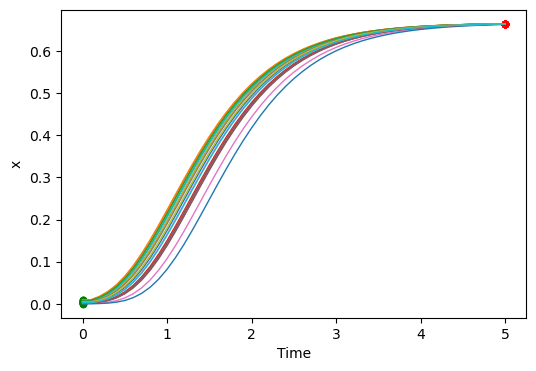

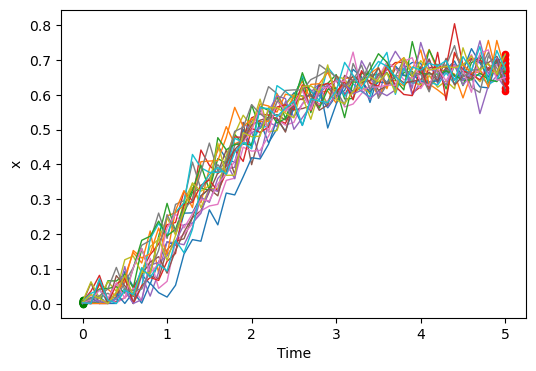

In [13]:
# Existence conditions:
Xtrain_noise = SINDy_data.existence_conditions(Xtrain_noise, init_low, dim_x)
SINDy_data.plot_configuration(Xtrain, T)
SINDy_data.plot_configuration(Xtrain_noise, T)

In [4]:
# Genetic Programming settings:

# Algebric diff:
alg = 'tv'

# Seeds:
seed = 100
n_seed = 1

# Configuration:
config = {
    'population_size': 15000,
    'p_crossover': 0.6903,
    'p_subtree_mutation': 0.133,
    'p_hoist_mutation': 0.0361,
    'p_point_mutation': 0.0905,
    'function_set': {'neg': 1, 'mul': 3, 'log': 1, 'add': 1},
    'const_range': (1, 2),
    'generations': 20,
    'stopping_criteria': 0.01,
    'max_samples': 0.9,
    'verbose': 1,
    'parsimony_coefficient': 0.01,
    'init_depth': (1, 6),
    'n_jobs': 2,
    'low_memory': True
}

# Run Genetic Programming optimization:
run_GP(X_list=Xtrain, x_id=0, freq=freq, 
       dim_x=dim_x, init_low=init_low, init_high=init_high, n_sample=n_sample, alg=alg, 
       seed=seed, n_seed=n_seed, noise=False, config=config, 
       T0=0, T=5.) 
None

Dataset shape:  (51, 20, 1)
Functions set:  {'neg': 1, 'mul': 3, 'log': 1, 'add': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    19.78      9.83724e+10        9        0.0104353        0.0106554      3.05m
   1     7.34          607.516        9        0.0103627        0.0113086      2.62m
   2     4.08          112.412        9        0.0103097        0.0117851      2.66m
   3     2.94          131.697        9       0.00659013       0.00567391      2.36m
   4     4.40           134.22        9        0.0021568       0.00288975      2.30m
   5     7.79          7634.78        9       0.00166589         0.001025      2.08m
   6     9.02          506.205        9       0.00152148       0.00232469      1.97m
   7     9.07          138.568        9       0.00145783       0.00289757